

## Dados do aluno

Jackes Tiago Ferreira da Fonseca - 190030291

## Objetivo

Fazer a distinção entre um local que seria apropriado ou não para o pouso de um Drone definindo o melhor modelo para o dataset e por fim realizar o Deploy da aplicação.



## Motivação

Esse modelo poderá ser aplicado em sistemas embarcados a fim de proporcinonar uma forma para que Drones identifiquem locais seguros para aterrissagem impedindo danos e perdas.

## Modelagem

## 1. Atualizando dependências

In [21]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install -Uqq fastai

In [23]:
!pip install -U timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Obtendo Dataset 

Será utilizado um dataset com 150 imagens separadas em três categorias:

- Asfalto (50 imagens)
- Grama (50 imagens)
- Perigo (50 imagens)

Tal dataset foi preparado previamente e armazenado no Google Drive

In [24]:
import timm
from fastcore.all import *

In [25]:
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

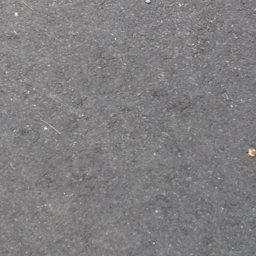

In [26]:
Image.open('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/safe_or_danger/asphalt/asphalt_01.png').to_thumb(256,256)

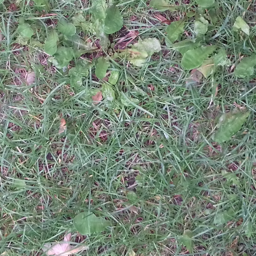

In [27]:
Image.open('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/safe_or_danger/grass/grass_01.png').to_thumb(256,256)

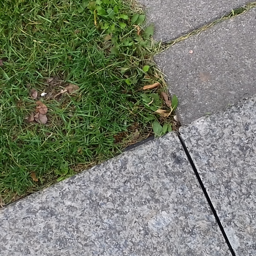

In [28]:
Image.open('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/safe_or_danger/danger/danger_01.png').to_thumb(256,256)

In [29]:
path = Path('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/safe_or_danger');

## 3. Treinando o modelo

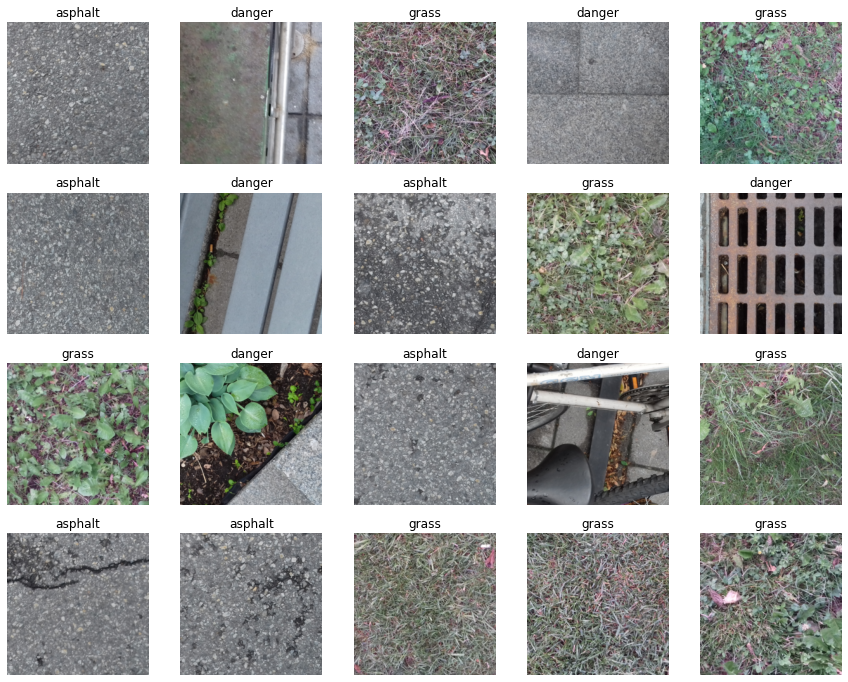

In [30]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

## 4. Definindo o melhor modelo

Em geral, existem vários modelos pré treinados de Machine Learning. No Pytorch, por exemplo, são mais de 500 tipos diferentes. Todas elas são, basicamente, funções matemáticas - multiplicações de matrizes não lineares como RELUs. Aqui, nesse momento, o que irei levar em consideração para analisar os modelos são três coisas:

- Qual sua velocidade
- Quanto de memória consome
- Qual sua precisão

**OBS.:** O trecho de código a seguir foi feito por *Ross Wightman* e refatorado por *Jeremy Howard*. Para mais informações clique [aqui](https://www.kaggle.com/code/jhoward/which-image-models-are-best) e veja o notebook original e completo.

In [33]:
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (507/507), done.
remote: Compressing objects: 100% (354/354), done.
remote: Total 507 (delta 207), reused 362 (delta 144), pack-reused 0
Receiving objects: 100% (507/507), 1.14 MiB | 2.21 MiB/s, done.
Resolving deltas: 100% (207/207), done.
/content/empty/results/pytorch-image-models/results


In [34]:
import pandas as pd
df_results = pd.read_csv('results-imagenet.csv')

In [35]:
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg')]

In [36]:
df = get_data('infer', 'infer_samples_per_sec')

In [37]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

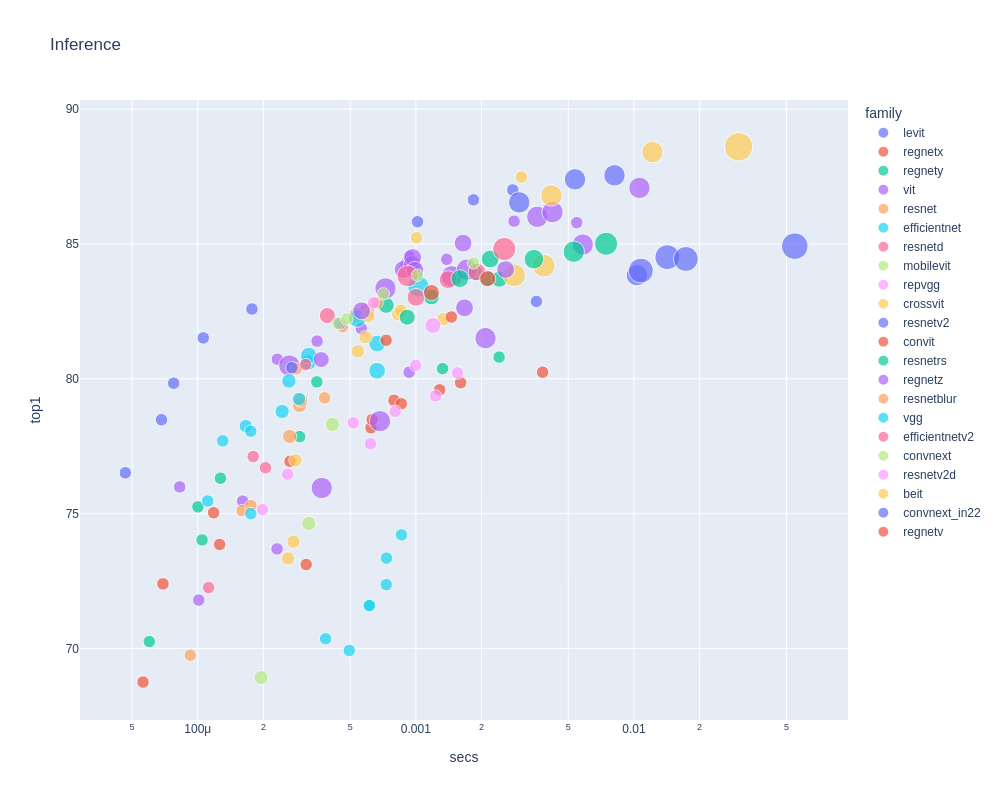

O gráfico acima apresenta a distribuição de modelos organizados dentro de uma mesma família sendo que:

- Quanto mais a esquerda mais rápido é o modelo
- Quanto mais acima maior sua precisão

Podemos, então, observar que as famílias *beit* e *convnext* são as que possuem maior precisão. E as famílias *levit* e *regnetx* são as que possuem maior velocidade de processamento.

Pelo fato do redimensionamento do nosso dataset ser de 224x224 pixels, para testarmos o melhor modelo que se adequa a esse dataset, iremos utilizar apenas aqueles que aceitam esse tipo de dimensionamento. Iremos também utilizar o método *squish* do fast ai, que deforma a imagem mas utiliza todos os pixels dela, para ajustar nossas imagens. Por base, teremos o *resnet18*, por ser um dos modelos mais populares utilizados no processamento de imagens. Além desse, também serão utilizados outros modelos das famílias *resnet*, *levit*, *convinext* e *regnetx*. Esses modelos foram escolhidos com base no artigo [Finding the New Resnet18](https://wandb.ai/fastai/fine_tune_timm/reports/Finding-the-New-Resnet18--VmlldzoyMDI0MjU3).



## 4.1. Resnet18

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.014170,1.699664,0.666667,00:24


epoch,train_loss,valid_loss,error_rate,time
0,2.246910,1.337297,0.633333,00:29
1,1.904021,0.636800,0.300000,00:27
2,1.401229,0.308551,0.066667,00:26


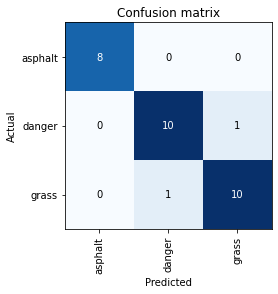

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 4.2. Resnet50

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.915609,1.271859,0.566667,00:49


epoch,train_loss,valid_loss,error_rate,time
0,1.418975,0.816901,0.366667,01:01
1,0.843539,0.345201,0.133333,01:02
2,0.588185,0.207212,0.066667,00:58


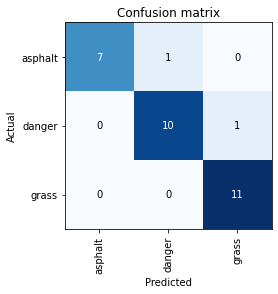

In [ ]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 4.3. Levit_256

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-256-13b5763e.pth" to /root/.cache/torch/hub/checkpoints/LeViT-256-13b5763e.pth
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.937139,3.084218,0.833333,00:35


epoch,train_loss,valid_loss,error_rate,time
0,1.423935,2.486866,0.733333,00:27
1,1.323851,1.828590,0.633333,00:24
2,1.316103,1.497140,0.500000,00:26


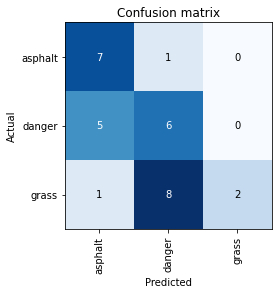

In [ ]:
learn = vision_learner(dls, 'levit_256', metrics=error_rate).to_fp16()
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 4.4. Convnext_tiny

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.685100,1.460706,0.666667,00:57


epoch,train_loss,valid_loss,error_rate,time
0,1.392678,0.931122,0.333333,06:07
1,1.296519,0.593353,0.166667,06:07
2,0.958494,0.396064,0.100000,06:05


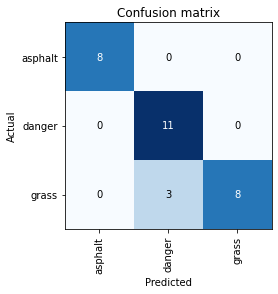

In [18]:
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate).to_fp16()
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 4.5. Regnetx_032

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.970312,1.371702,0.666667,01:08


epoch,train_loss,valid_loss,error_rate,time
0,2.308920,0.944256,0.433333,01:00
1,1.934003,0.478766,0.166667,00:54
2,1.370561,0.318931,0.066667,00:55


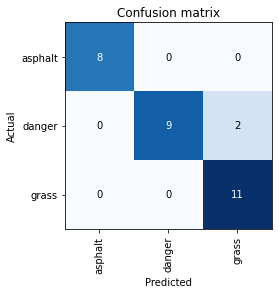

In [31]:
learn = vision_learner(dls, 'regnetx_032', metrics=error_rate).to_fp16()
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# 5. Resultados

Podemos observar por meio da matriz de confusão que obtivemos melhores resultados utilizando o *resnet18*, *resnet50* e *regnetx_032*. Dentre essas arquiteturas temos que a *resnet18* foi a que executou em menos tempo, confirmando sua grande fama dentro do processamento de imagens. Temos também que *regnetx_032* teve uma excelente exibição - rápido, preciso e não consome muita memória. O *convnext_tiny* ainda apresenta um bom desempenho, mas decepciona um pouco devido sua velocidade relativamente baixa. Outro ponto positivo das arquiteturas baseadas nas famílias *convnext* é a capacidade de lidar com entradas de tamanho dinâmico, diferente de modelos baseados em transformadores - não usam Redes Neurais Recorrentes (RNN), como *vit* e *swin*.



# 6. Deploy

O aplicativo foi hospedsado no HuggingFace Space e pode ser acesssado clicando no link abaixo

[FastAi - Modelo Drone](https://huggingface.co/spaces/jackesfonseca/lesson03)

# 7. Conclusão

Fizemos algumas experiências aqui e descobrimos que agora temos modelos tão bons quanto o confiável *resnet18*. Existem duas dimensões principais nas quais os conjuntos de dados podem variar quando se trata de quão bem eles ajustam um modelo:

- Quão semelhantes eles são ao conjunto de dados do modelo pré-treinado
- Quão grandes eles são

    
